Epoch 1/91


c:\Users\haypr\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.1441 - val_loss: 0.0291
Epoch 2/91
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0346 - val_loss: 0.0171
Epoch 3/91
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0314 - val_loss: 0.0163
Epoch 4/91
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0288 - val_loss: 0.0162
Epoch 5/91
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0292 - val_loss: 0.0158
Epoch 6/91
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0272 - val_loss: 0.0181
Epoch 7/91
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0293 - val_loss: 0.0157
Epoch 8/91
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0280 - val_loss: 0.0163
Epoch 9/91
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0287 - val_loss: 0.0156
Epoch 10/91
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0303 - val_loss: 0.0174
Epoch 11/91
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0293 - val_loss: 0.0157
Epoch 12/91
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0296 - val_l

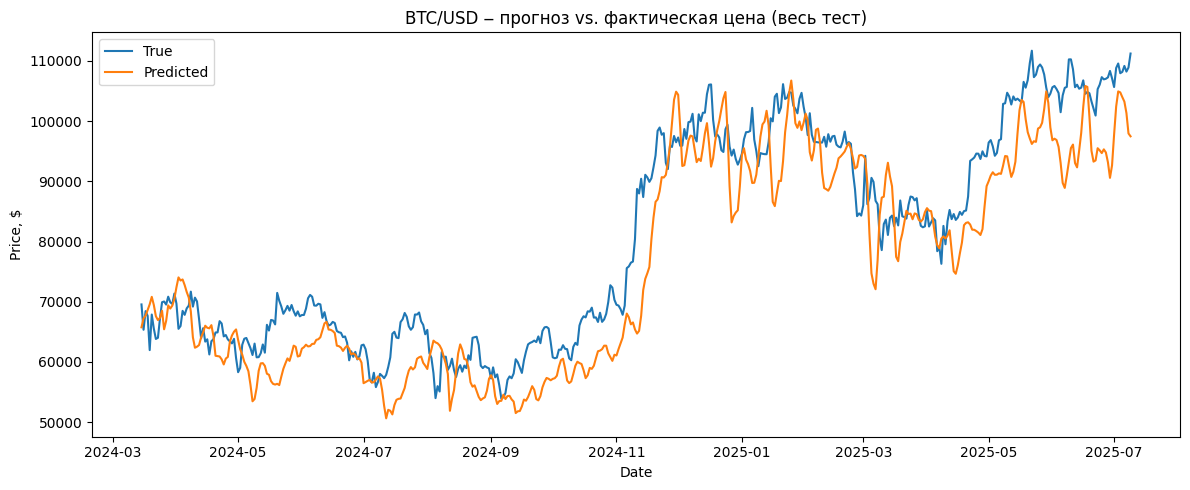

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import requests

# --- 1. Загрузка данных из CSV ---
df = pd.read_csv("btc_ohlcv_full_period.csv", parse_dates=["timestamp"])

# Приводим имена колонок к нужному виду
df = df.rename(columns={
    "timestamp": "open_time",
    "price_open": "open",
    "price_high": "high",
    "price_low": "low",
    "price_close": "close",
    "volume_traded": "volume"
})
df.set_index(['symbol', 'open_time'], inplace=True)

# --- 2. Параметры ---
FEATURE_COLS = ['open', 'high', 'low', 'close', 'volume']
time_steps = 120
horizon = 7
target_col = 'close'
symbol = 'BINANCEFTS_PERP_BTC_USDT'

# --- 3. Масштабирование ---
feature_scalers = {symbol: MinMaxScaler()}
df_btc = df.xs(symbol, level='symbol')
df_scaled = pd.DataFrame(
    feature_scalers[symbol].fit_transform(df_btc[FEATURE_COLS]),
    columns=FEATURE_COLS,
    index=df_btc.index
)

# --- 4. Разделение данных ---
train_size = int(len(df_scaled) * 0.7)
train_scaled = df_scaled.iloc[:train_size]
test_scaled = df_scaled.iloc[train_size:]

# --- 5. Функция для создания последовательностей ---
def create_sequences(df_sym, feature_cols, time_steps, horizon, target_col):
    X, y, dates = [], [], []
    values = df_sym[feature_cols].values
    for i in range(len(values) - time_steps - horizon + 1):
        X.append(values[i:i + time_steps])
        target_idx = i + time_steps + horizon - 1
        y.append(values[target_idx, feature_cols.index(target_col)])
        dates.append(df_sym.index[target_idx])
    return np.array(X), np.array(y), np.array(dates)

# --- 6. Обучение модели ---
X_train, y_train, _ = create_sequences(
    train_scaled, FEATURE_COLS, time_steps, horizon, target_col
)
model = Sequential([
    LSTM(50, activation='relu', input_shape=(time_steps, len(FEATURE_COLS))),
    Dense(1)
])
model.compile(optimizer='adam', loss='mae')
model.fit(X_train, y_train, epochs=91, batch_size=32, validation_split=0.2, verbose=1)

# --- 7. Последовательности для теста ---
df_btc_test = test_scaled
X_btc, y_btc_scaled, dates_btc = create_sequences(
    df_btc_test, FEATURE_COLS, time_steps, horizon, target_col
)

# --- 8. Прогноз ---
y_btc_pred_scaled = model.predict(X_btc, verbose=0).flatten()

# --- 9. Обратное преобразование ---
scaler_btc = feature_scalers[symbol]
close_idx = FEATURE_COLS.index(target_col)

def inv_transform_close(scaled_vec):
    tmp = np.zeros((scaled_vec.shape[0], len(FEATURE_COLS)))
    tmp[:, close_idx] = scaled_vec
    log_close = scaler_btc.inverse_transform(tmp)[:, close_idx]
    return log_close  # Убрал np.exp, так как Binance данные не логарифмированы

true_prices = inv_transform_close(y_btc_scaled)
pred_prices = inv_transform_close(y_btc_pred_scaled)

# --- 10. Датафрейм с результатами ---
btc_preds = pd.DataFrame({
    'date': pd.to_datetime(dates_btc),
    'true_price': true_prices,
    'pred_price': pred_prices
}).set_index('date')

# --- Метрики ---
mse = mean_squared_error(btc_preds.true_price, btc_preds.pred_price)
rmse = np.sqrt(mse)  # Исправление для RMSE
mae = mean_absolute_error(btc_preds.true_price, btc_preds.pred_price)

mean_price = btc_preds.true_price.mean()
rmse_pct = rmse / mean_price * 100
mae_pct = mae / mean_price * 100

print(f"RMSE  : {rmse:,.2f}  ({rmse_pct:.2f}% of mean price)")
print(f"MAE   : {mae:,.2f}   ({mae_pct:.2f}% of mean price)")
print(btc_preds.head())

# --- График ---
plt.figure(figsize=(12, 5))
plt.plot(btc_preds.index, btc_preds.true_price, label='True')
plt.plot(btc_preds.index, btc_preds.pred_price, label='Predicted')
plt.title('BTC/USD ‒ прогноз vs. фактическая цена (весь тест)')
plt.xlabel('Date')
plt.ylabel('Price, $')
plt.legend()
plt.tight_layout()
plt.show()